In [1]:
from googleads import adwords
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import math
import datetime
import pandas as pd
import gdn_datacollector as collector
import google_adwords_controller as controller
import database_controller
import gdn_db
import adgeek_permission as permission

In [2]:
sizepop, vardim, MAXGEN, params = 1000, 7, 15, [0.9, 0.5, 0.5]
# sizepop, vardim, MAXGEN, params = 1000, 3, 10, [0.9, 0.5, 0.5]
ASSESSMENT_PERIOD = 14
BIDDING_INDEX = {
    'cpc': 'cpc_bid',
    'cpa': 'cpa_bid',
    'Target CPA': 'cpa_bid',    
}
TARGET_INDEX = {
    'cpc': 'clicks',
    'cpa': 'conversions',
    'Target CPA': 'cpa_bid',
}
CRITERIA_LIST = ['ADGROUP', 'URL', 'CRITERIA', 'AGE_RANGE', 'DISPLAY_KEYWORD', 'AUDIENCE', 'DISPLAY_TOPICS']

SCORE_COLUMN_INDEX = {
    'ADGROUP': ['campaign_id', 'adgroup_id', 'score'],
    'URL': ['campaign_id', 'adgroup_id', 'url_display_name', 'score'],
    'CRITERIA': ['campaign_id', 'adgroup_id', 'keyword_placement', 'keyword_id', 'score'],
    'AUDIENCE': ['campaign_id', 'adgroup_id', 'audience', 'criterion_id', 'score'],
    'AGE_RANGE': ['campaign_id', 'adgroup_id', 'age_range', 'criterion_id', 'score'],
    'DISPLAY_KEYWORD': ['campaign_id', 'adgroup_id', 'keyword', 'keyword_id', 'score'],
    'KEYWORDS': ['campaign_id', 'adgroup_id', 'keyword', 'keyword_id', 'score'],
    'DISPLAY_TOPICS': ['campaign_id', 'adgroup_id', 'topics', 'criterion_id', 'vertical_id', 'score'],
}

In [3]:
def retrive_all_criteria_insights():
    campaign_list = database_gdn.get_running_campaign().to_dict('records')
    # retrive all criteria insights
    for campaign in campaign_list:
        print('[campaign_id]: ', campaign['campaign_id'])
        customer_id = campaign['customer_id']
        destination_type = campaign['destination_type']
        adwords_client = permission.init_google_api(customer_id)
        camp = gdn_datacollector.Campaign(customer_id, campaign_id, database_gdn=database_gdn)
        for criteria in CRITERIA_LIST:
            camp.get_performance_insights( performance_type=criteria, date_preset='LAST_14_DAYS' )

In [4]:
def get_criteria_score( campaign_id=None, criteria=None, insights_dict=None):
    df = database_gdn.retrieve(criteria.lower()+"_insights", campaign_id=campaign_id)
    # Get optimal_weight from db
    df_weight = database_gdn.retrieve("optimal_weight", campaign_id=campaign_id)

    if not df.empty:
        if criteria != "URL" and criteria != "CRITERIA":
            df['daily_budget'] = insights_dict['daily_budget']
            df['bid_amount'] = df[ BIDDING_INDEX[ df['bidding_type'].iloc[0] ] ]
            df['target'] = df[ TARGET_INDEX[ df['bidding_type'].iloc[0] ] ]
            daily_destination = (insights_dict['destination']/insights_dict['period'])
            df['daily_destination'] = daily_destination
            df['conv_rate'] = (insights_dict['all_conversions']+insights_dict['conversions'])/insights_dict['clicks'] if insights_dict['clicks']!=0 else 1
            if insights_dict['destination_type']=='LINK_CLICKS':
                df['all_conversions'] = 1 if insights_dict['all_conversions']>0 else 0
                df['view_conversions'] = 1 if insights_dict['view_conversions']>0 else 0
                df['conversions'] = 1 if insights_dict['conversions']>0 else 0
            elif insights_dict['destination_type']=='CONVERSIONS':
                df['cost_per_target'] = insights_dict['cost_per_conversion']
                df['all_conversions'] = 1 if insights_dict['all_conversions']>0 else -100
                df['view_conversions'] = 1 if insights_dict['view_conversions']>0 else -100
                df['conversions'] = 1 if insights_dict['conversions']>0 else -100

            for index, row in df.iterrows():
                df = pd.DataFrame(data=[row], columns=df.columns, index=[0])
                r = ObjectiveFunc.adgroup_fitness(df_weight, df)
                df['score'] = r
                df_final = df[ SCORE_COLUMN_INDEX[criteria] ]
                database_gdn.insert_ignore("adgroup_initial_bid", df_final.to_dict('records'))

In [5]:
class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''

    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculate_fitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
#         self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#         self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        self.trace[self.t, 0] = self.best.fitness
        self.trace[self.t, 1] = self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selection_operation()
            self.crossover_operation()
            self.mutation_operation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print("Optimal solution is:")
        print(self.best.chrom)
        self.print_result()
        return self.best.chrom

    def selection_operation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossover_operation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutation_operation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def print_result(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()


class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''

    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]

    def calculate_fitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        optimal_weight = OptimalWeight(self.chrom)
        self.fitness = np.dot(optimal_weight.matrix, chromosome.matrix)


class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''
    def fitnessfunc(optimal_weight, df):
        
        m_kpi = ( df['campaign_click'] / df['daily_destination'] ).apply(np.tanh)
        m_spend = ( (df['spend_cap'] - df['spend']) / df['spend_cap'] ).apply(np.exp)
        m_bid = ( (df['campaign_bid'] - df['campaign_cpc']) / df['campaign_bid'] ).apply(np.exp)
        
        # We consider all_conv for converiosn campaign
        #[conv, all_conv, (conv+all_conv)/clicks, m_kpi, m_spend, m_bid]
        m_all_conv = df['campaign_all_conv']
        m_view_conv = df['campaign_view_conv']
        m_conv = df['campaign_conversion']
        m_conv_rate = df['campaign_conv_rate']
        
        m_bid = m_bid if df['campaign_cpc'].iloc[0]!=0 else pd.Series([-1], index=[0])
        
        status = np.array([m_conv, m_view_conv, m_all_conv, m_conv_rate, m_kpi, m_spend, m_bid])
        r = np.dot(optimal_weight, status)
        return r

    def adgroup_fitness(optimal_weight, df):
        m_kpi = ( df['target'] / df['daily_destination'] ).apply(np.tanh) * 2
        m_kpi = pd.Series([-10], index=[0]) if df['target'].iloc[0] == 0 else m_kpi
        
        m_spend = ( (df['daily_budget'] - df['spend']) / df['daily_budget'] ).apply(np.tanh) * 10
        m_bid = ((df['bid_amount'] - df['cost_per_target']) / df['bid_amount']).astype(float).apply(np.exp)
        
        m_all_conv = df['all_conversions']
        m_view_conv = df['view_conversions']
        m_conv = df['conversions']
        with np.errstate(divide='ignore', invalid='ignore'):
            m_conv_rate = np.true_divide( df['all_conversions'], df['clicks'] )
            m_conv_rate[m_conv_rate == np.inf] = -10
            m_conv_rate[m_conv_rate == -np.inf] = -10
            m_conv_rate = np.nan_to_num(m_conv_rate)
#         m_conv_rate = pd.Series([0], index=[0])
        status = np.array([m_conv, m_view_conv, m_all_conv, m_conv_rate, m_kpi, m_spend, m_bid])
        optimal_weight = np.array([
            optimal_weight['weight_conv'].iloc[0],
            optimal_weight['weight_view_conv'].iloc[0],
            optimal_weight['weight_all_conv'].iloc[0],
            optimal_weight['weight_conv_rate'].iloc[0],
            optimal_weight['weight_kpi'].iloc[0],
            optimal_weight['weight_spend'].iloc[0],
            optimal_weight['weight_bid'].iloc[0]
        ])
        r = np.dot(optimal_weight, status)
        return r

    def campaign_status(self, campaign_id, insights_dict):
        destination_type = insights_dict['destination_type']
        spend = insights_dict['spend']
        daily_budget = insights_dict['daily_budget']
        campaign_click = insights_dict['clicks']
        impressions = insights_dict['impressions']
        spend_cap = insights_dict['daily_budget'] * ASSESSMENT_PERIOD
        daily_destination = (insights_dict['destination']/insights_dict['period'])
        campaign_bid = daily_budget/daily_destination
        campaign_conv_rate = (insights_dict['all_conversions']+insights_dict['conversions'])/insights_dict['clicks'] if insights_dict['clicks']!=0 else 1
        campaign_cpt, campaign_all_conv, campaign_conversion = 0, 0, 0
        if destination_type=='LINK_CLICKS':
            campaign_cpt = insights_dict['cost_per_click']
            campaign_all_conv = 1 if insights_dict['all_conversions'] > 0 else 0
            campaign_view_conv = 1 if insights_dict['view_conversions'] > 0 else 0
            campaign_conversion = 1 if insights_dict['conversions'] > 0 else 0
        elif destination_type=='CONVERSIONS':
            campaign_cpt = insights_dict['cost_per_conversion']
            campaign_all_conv = 1 if insights_dict['all_conversions'] > 0 else -1
            campaign_view_conv = 1 if insights_dict['view_conversions'] > 0 else -1
            campaign_conversion = 1 if insights_dict['conversions'] > 0 else -2

        campaign_status_dict = {
            'campaign_id': [campaign_id],
            'campaign_cpc': [campaign_cpt],
            'campaign_conversion': [campaign_conversion],
            'campaign_click': [campaign_click],
            'campaign_all_conv': [campaign_all_conv],
            'campaign_view_conv': [campaign_view_conv],
            'campaign_conversion': [campaign_conversion],
            'campaign_conv_rate': [campaign_conv_rate],
            'impressions': [impressions],
            'campaign_bid': [campaign_bid],
            'spend': [spend],
            'daily_budget': [daily_budget],
            'daily_destination': [daily_destination],
            'spend_cap': [spend_cap]
        }
        df = pd.DataFrame(campaign_status_dict)
        df = df.convert_objects(convert_numeric=True)
        return df

    def adgroup_status(self, adgroup_id):
        return


In [3]:
def generate_optimal_weight(campaign_id, charge_type):
    global chromosome
    print('[campaign_id]:', campaign_id )
    print('[current time]: ', datetime.datetime.now() )
    start_time = datetime.datetime.now()
    
    campaign = Campaign(campaign_id)
    chromosome = ObjectChromosome(campaign.condition)

    bound = np.tile([[0], [1]], vardim)
    ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
    result_optimal_weight = ga.solve()
    
    optimal_campaign = CampaignOptimalWeight(campaign_id, charge_type, result_optimal_weight)
    
    score = np.dot(optimal_campaign.matrix, chromosome.matrix)
    print('==========SCORE========')
    print(score)

    score_columns=['w_action', 'w_desire', 'w_interest', 'w_awareness', 'w_discovery', 'w_spend', 'w_bid']
    df_score = pd.DataFrame(data=[optimal_campaign.matrix], columns=score_columns, index=[0])
    df_score['campaign_id'], df_score['score'] = campaign_id, score

    database_gdn.upsert("optimal_weight", df_score.to_dict('records')[0])

    assess_ad_group(campaign, optimal_campaign)

    print('[optimal_weight]:', optimal_campaign.matrix)
    print('[operation time]: ', datetime.datetime.now()-start_time)

In [4]:
def assess_ad_group(campaign_object, campaign_optimal_object):
    for ad_group in campaign_object.ad_groups:
        
        chromosome_ad_group = ObjectChromosome(ad_group.condition)
        
        score = np.dot(campaign_optimal_object.matrix, chromosome_ad_group.matrix)
        
        print('=====[adgroup_id]=====', ad_group.ad_group_id, '==========[score]', score)

        database_gdn.insert(
            "adgroup_score", 
            {'campaign_id':campaign_object.campaign_id, 'adgroup_id':ad_group.ad_group_id, 'score':score.item()}
        )


In [6]:
class Campaign(object):
    __condition_field = [
        'customer_id', 'campaign_id', 'channel_type', 'status', 'bidding_type', 'daily_budget', 'spend',
        'cost_per_target', 'impressions', 'clicks', 'conversions', 'all_conversions', 'cost_per_click', 'cost_per_conversion',
        'cost_per_all_conversion', 'ctr', 'view_conversions']
    def __init__(self, campaign_id):
        self.campaign_id = campaign_id
        self.__get_brief()
        self.brief_dict["destination_type"] = self.brief_dict.pop("charge_type")
        self.destination_type = self.brief_dict.get("destination_type")
        self.collector_campaign = collector.Campaign(
            self.brief_dict.get("customer_id"), self.campaign_id, database_gdn=database_gdn)
        self.service_container = controller.AdGroupServiceContainer(self.brief_dict.get("customer_id"))
        self.controller_campaign = controller.Campaign(self.service_container, self.campaign_id)
        self.__create_condition()
        self.__get_ad_groups()
        
    def __get_brief(self):
        df_list = database_gdn.get_one_campaign(self.campaign_id).to_dict('records')

        self.brief_dict = df_list[0]
        self.brief_dict['KPI'] = self.brief_dict.get("ai_spend_cap")/self.brief_dict.get("destination")
    
    def get_weight(self):
        optimal_weight_list = database_gdn.retrieve("optimal_weight", self.campaign_id).to_dict('records')
        
        return optimal_weight_list[0]
        
    def __get_ad_groups(self):
        self.controller_campaign.generate_ad_group_id_type_list()
        ad_group_id_list = native_ad_group_id_list
        self.ad_groups = [ AdGroup(self, ad_group_id) for ad_group_id in ad_group_id_list ]
        
    def __create_condition(self):
        self.condition = self.collector_campaign.generate_info(date_preset = collector.DatePreset.lifetime)
        self.condition.update(self.brief_dict)
        self.condition.update({
            "flight": (datetime.date.today()-self.brief_dict.get("ai_start_date")).days
        })
        self.condition['spend'] = int(self.condition.get("spend", 0))
        self.condition['impressions'] = int(self.condition.get("impressions", 0))
        self.condition.update({
            "attention": self.condition.get("impressions"),
            "discovery": self.condition.get("reach"),
            "destination_daily_spend": self.condition.get("ai_spend_cap") / self.condition.get("period"),
            "destination_daily_target":self.condition.get("destination") / self.condition.get("period"),
            "cost_per_action": self.condition.get("cost_per_target", 0),
            "spend": self.condition.get("spend") / self.condition.get("flight") if self.condition.get("flight") != 0 else 1,
            "action": self.condition.get("target") / self.condition.get("flight") if self.condition.get("flight") != 0 else 1,
        })
        self.condition = {k: v for k, v in self.condition.items() if k in self.__condition_field}
        
        
class AdGroup(object):
    __condition_field = [
        'customer_id', 'campaign_id', 'channel_type', 'adgroup_id', 'status', 'cpm_bid', 'cpv_bid', 'cpc_bid', 'cpa_bid',
        'bidding_type', 'spend', 'cost_per_target', 'impressions', 'clicks', 'conversions', 'all_conversions',
        'cost_per_click', 'cost_per_conversion', 'cost_per_all_conversion', 'ctr' ]
    def __init__(self, campaign, ad_group_id):
        self.campaign = campaign
        self.ad_group_id = ad_group_id
        self.destination_type = self.campaign.destination_type
        self.collector_ad_group = collector.AdGroup(self.ad_group_id, charge_type=None)
        self.__create_condition()
        
    def __create_condition(self):
        self.condition = self.collector_ad_group.generate_info(date_preset = collector.DatePreset.lifetime)
        self.condition['spend'] = float(self.condition.get("spend", 0))
        self.condition['impressions'] = int(self.condition.get("impressions", 0))
        self.condition.update({
            "KPI": self.campaign.condition.get("KPI"),
            "destination_type": self.destination_type,
            "destination_daily_spend": self.campaign.condition.get("destination_daily_spend"),
            "destination_daily_target": self.campaign.condition.get("destination_daily_target"),
            "cost_per_action": int(self.condition.get("spend")) / int(self.condition.get("action")) if int(self.condition.get("action")) != 0 else 0
        })
        self.condition = {k: v for k, v in self.condition.items() if k in self.__condition_field}
        
    def __create_fitness(self):
        self.fitness = Chromosome(self.condition)
        
    def __create_optimal_weight(self):
        self.optimal_weight = OptimalWeight(self.destination_type)



In [6]:
def main():
    starttime = datetime.datetime.now()
    global database_gdn
    db = database_controller.Database()
    database_gdn = database_controller.GDN(db)
    retrive_all_criteria_insights()
    df_camp = gdn_db.get_campaign()
    campaign_id_list = df_camp['campaign_id'].tolist()
    print('[campaign_id list]: ', campaign_id_list)
    for campaign_id in campaign_id_list:
        print('[current time]: ', datetime.datetime.now())
        print('[campaign_id]:', campaign_id )
        customer_id = df_camp['customer_id'][df_camp.campaign_id==campaign_id].iloc[0]
        destination_type = df_camp['destination_type'][df_camp.campaign_id==campaign_id].iloc[0]
        camp = gdn_datacollector.Campaign(customer_id, campaign_id, destination_type)
        date_preset = 'LAST_14_DAYS' if destination_type=='CONVERSIONS' else 'YESTERDAY'
        insights_dict = camp.get_campaign_insights(date_preset=date_preset)
        insights_dict['period'] = df_camp['period'][df_camp.campaign_id==campaign_id].iloc[0]
        insights_dict['destination'] = df_camp['destination'][df_camp.campaign_id==campaign_id].iloc[0]
        insights_dict['destination_type'] = destination_type
        global df
        df = ObjectiveFunc().campaign_status( campaign_id, insights_dict )
        bound = np.tile([[0], [1]], vardim)
        ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
        optimal = ga.solve()
        score = ObjectiveFunc.fitnessfunc(optimal, df)

        score_columns=['weight_conv', 'weight_view_conv','weight_all_conv','weight_conv_rate','weight_kpi', 'weight_spend', 'weight_bid']
        df_score = pd.DataFrame(data=[optimal], columns=score_columns, index=[0])

        df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
        df_final = pd.concat( [df_score, df_final], axis=1, sort=True, ignore_index=False)
        print(df_final.to_dict('records'))
        gdn_db.check_optimal_weight(campaign_id, df_final)
        for criteria in CRITERIA_LIST:
            get_criteria_score( campaign_id=campaign_id, criteria=criteria, insights_dict=insights_dict )
        
        print('optimal_weight:', optimal)
        print(datetime.datetime.now()-starttime)
    print(datetime.datetime.now()-starttime)
    import gc
    gc.collect()

[campaign_id]:  2080506438
[get_media_token_by_queryid] token_dic {'credential_id': '383662757090-j7mjkvtt22dp44ae08l8ns4a1qu1jaq2.apps.googleusercontent.com', 'credential_secret': 'DC84vPzbgnKhkpmVO7htA46h', 'credential_token': None, 'credential_developer_token': 'OteLlPsJQdjV9ph_NzdODg', 'credential_refresh_token': '1/3ox-mppBSpSLb3GjiWKbE8Q2CRmAmNfWFIHwkbkiL-0', 'name': 'AntMan Google Credential'}
[get_media_token_by_queryid] token_dic {'credential_id': '383662757090-j7mjkvtt22dp44ae08l8ns4a1qu1jaq2.apps.googleusercontent.com', 'credential_secret': 'DC84vPzbgnKhkpmVO7htA46h', 'credential_token': None, 'credential_developer_token': 'OteLlPsJQdjV9ph_NzdODg', 'credential_refresh_token': '1/3ox-mppBSpSLb3GjiWKbE8Q2CRmAmNfWFIHwkbkiL-0', 'name': 'AntMan Google Credential'}
[gdn_datacollector.Campaign.get_performance_insights]:  DISPLAY_KEYWORD 0
[gdn_datacollector.Campaign.get_performance_insights]:  AUDIENCE 0
[campaign_id]:  6491023637
[get_media_token_by_queryid] token_dic {'credential

/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:293: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Generation 0: optimal function value is: 1.072053; average function value is -1.463125
Generation 1: optimal function value is: 1.072053; average function value is -1.950707
Generation 2: optimal function value is: 1.072053; average function value is -2.243588
Generation 3: optimal function value is: 1.072053; average function value is -2.406599
Generation 4: optimal function value is: 1.072053; average function value is -2.515794
Generation 5: optimal function value is: 1.072053; average function value is -2.617749
Generation 6: optimal function value is: 1.072053; average function value is -2.716157
Generation 7: optimal function value is: 1.072053; average function value is -2.796929
Generation 8: optimal function value is: 1.072053; average function value is -2.813892
Generation 9: optimal function value is: 1.072053; average function value is -2.873735
Generation 10: optimal function value is: 1.072053; average function value is -2.931008
Generation 11: optimal function value is: 

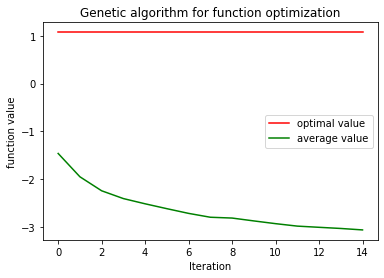

[{'weight_conv': 0.01436152877146546, 'weight_view_conv': 0.3229784541806251, 'weight_all_conv': 0.2759163686431352, 'weight_conv_rate': 0.21647084539411166, 'weight_kpi': 0.8585348676014126, 'weight_spend': 0.8492068305777715, 'weight_bid': 0.016112159326036157, 'campaign_id': 2080506438, 'score': 1.0720532553444908}]
optimal_weight: [0.01436153 0.32297845 0.27591637 0.21647085 0.85853487 0.84920683
 0.01611216]
0:01:31.036291
[current time]:  2019-10-01 11:42:13.157957
[campaign_id]: 6491023637
[get_media_token_by_queryid] token_dic {'credential_id': '383662757090-j7mjkvtt22dp44ae08l8ns4a1qu1jaq2.apps.googleusercontent.com', 'credential_secret': 'DC84vPzbgnKhkpmVO7htA46h', 'credential_token': None, 'credential_developer_token': 'OteLlPsJQdjV9ph_NzdODg', 'credential_refresh_token': '1/3ox-mppBSpSLb3GjiWKbE8Q2CRmAmNfWFIHwkbkiL-0', 'name': 'AntMan Google Credential'}
Generation 0: optimal function value is: 2.298036; average function value is -0.715301
Generation 1: optimal function val

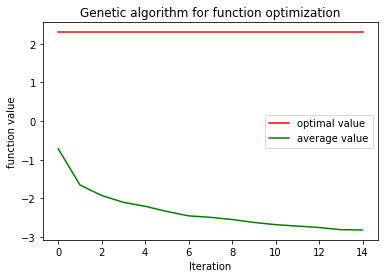

[{'weight_conv': 0.07988099118131231, 'weight_view_conv': 0.2628934480424904, 'weight_all_conv': 0.04850467635111899, 'weight_conv_rate': 0.9944295343460853, 'weight_kpi': 0.7125131717511496, 'weight_spend': 0.9201770177288177, 'weight_bid': 0.2896405656380059, 'campaign_id': 6491023637, 'score': 2.2980360703500358}]
optimal_weight: [0.07988099 0.26289345 0.04850468 0.99442953 0.71251317 0.92017702
 0.28964057]
0:02:24.723217
0:02:24.723350


In [7]:
if __name__ == "__main__":
    main()

In [1]:
# !jupyter nbconvert --to script genetic_algorithm_gdn.ipynb

[NbConvertApp] Converting notebook genetic_algorithm_gdn.ipynb to script
[NbConvertApp] Writing 19478 bytes to genetic_algorithm_gdn.py
